# Entrainement DQN pour Space Invaders IA

In [1]:
import dqn
from game_environnement.space_invaders_game.Code.Main import Game
from game_environnement.space_invaders_env import SpaceInvadersEnv
from dqn.dqn_agent import train_dqn
from dqn.dqn_agent import DQNAgent

import pygame
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

from train_cnn import X_train


/Users/Florian/Documents/Ecole/UQAC/Cours-Obsidian/Cours/Cours - UQAC/Fondamentaux de l apprentissage automatique/projets/Space Invaders/venv/lib/python3.12/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


pygame 2.6.1 (SDL 2.28.4, Python 3.12.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
pygame.init()

pygame.display.set_mode((100, 100))  

game = Game(600, 600, screen=None)
env = SpaceInvadersEnv(game)

print("=== DÉBUT DE L'ENTRAINEMENT DQN ===")
rewards = train_dqn(env, episodes=10)
print("=== FIN DE L'ENTRAINEMENT DQN ===")

=== DÉBUT DE L'ENTRAINEMENT DQN ===
Episode 1/10 - Reward: -123.88 - Epsilon: 0.995
Episode 2/10 - Reward: -139.07 - Epsilon: 0.990
Episode 3/10 - Reward: -63.28 - Epsilon: 0.985
Episode 4/10 - Reward: -145.66 - Epsilon: 0.980
Episode 5/10 - Reward: -36.27 - Epsilon: 0.975
Episode 6/10 - Reward: -18.35 - Epsilon: 0.970
Episode 7/10 - Reward: -66.98 - Epsilon: 0.966
Episode 8/10 - Reward: -47.78 - Epsilon: 0.961
Episode 9/10 - Reward: -102.14 - Epsilon: 0.956
Episode 10/10 - Reward: -29.63 - Epsilon: 0.951
Entraînement terminé. Sauvegarde du modèle...
Modèle sauvegardé sous 'dqn_space_invaders.pth'
=== FIN DE L'ENTRAINEMENT DQN ===


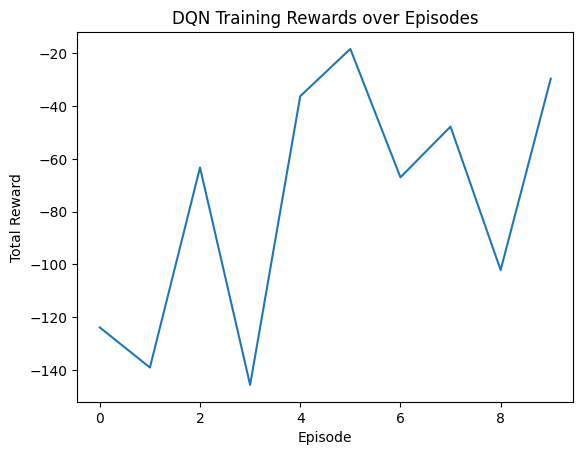

In [3]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('DQN Training Rewards over Episodes')
plt.show()

## Épisodes de test

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# -- DÉTECTION TAILLE & AGENT ---
initial_state = env.reset()
#real_state_size = initial_state.shape[0]
real_state_size = 6
action_size = 4
agent = DQNAgent(real_state_size, action_size)

# --- CHARGEMENT MODÈLE ---
model_path = "models/dqn_space_invaders.pth"
device = torch.device("cpu") # CPU obligatoire pour éviter les conflits
agent.device = device
agent.q_network.to(device)

try:
    print("Dossier courant :", os.getcwd())
    checkpoint = torch.load(model_path, map_location=device)
    if isinstance(checkpoint, dict) and 'state_size' not in checkpoint:
        agent.q_network.load_state_dict(checkpoint)
    else:
        agent.q_network.load_state_dict(checkpoint)
    agent.q_network.eval()
    print("Cerveau de l'IA chargé !")
except FileNotFoundError:
    print(f"Fichier '{model_path}' introuvable.")
    pygame.quit()
    raise SystemExit

Dossier courant : /Users/Florian/Documents/Ecole/UQAC/Cours-Obsidian/Cours/Cours - UQAC/Fondamentaux de l apprentissage automatique/projets/Space Invaders/game_environnement/space_invaders_game/Code
Cerveau de l'IA chargé !


In [5]:
def evaluate_agent(env, agent, n_episodes=50):
    """
    Évalue les performances de l'agent sur n_episodes sans exploration.
    """
    print(f"--- Démarrage de l'évaluation sur {n_episodes} épisodes ---")
    
    # 1. Sauvegarder l'epsilon actuel et le mettre à 0 pour le test (Exploitation pure)
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    # Mettre le réseau en mode évaluation (pas de calcul de gradients inutile)
    agent.q_network.eval()
    
    game_scores = []      # Vrais scores du jeu (points affichés à l'écran)
    total_rewards = []    # Rewards cumulées (ce que l'IA optimise)
    steps_survived = []   # Durée de survie

    for i in range(n_episodes):
        state = env.reset()
        done = False
        episode_reward = 0
        episode_steps = 0
        
        while not done:
            # L'agent choisit l'action (sans aléatoire car epsilon=0)
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            
            state = next_state
            episode_reward += reward
            episode_steps += 1
            
        # Fin de l'épisode
        game_scores.append(env.game.score) # On récupère le score interne du jeu
        total_rewards.append(episode_reward)
        steps_survived.append(episode_steps)
        
        if (i+1) % 10 == 0:
            print(f"Episode {i+1}/{n_episodes} - Score Jeu: {env.game.score} - Reward: {episode_reward:.2f}")

    # 2. Restaurer la configuration de l'agent
    agent.epsilon = original_epsilon
    agent.q_network.train() # Remettre en mode train si besoin
    
    # 3. Calcul des statistiques
    avg_score = np.mean(game_scores)
    std_score = np.std(game_scores)
    max_score = np.max(game_scores)
    
    avg_reward = np.mean(total_rewards)
    avg_steps = np.mean(steps_survived)
    
    print("\n=== RÉSULTATS DE L'ÉVALUATION ===")
    print(f"Score Moyen (Jeu)   : {avg_score:.2f} ± {std_score:.2f}")
    print(f"Score Max (Jeu)     : {max_score}")
    print(f"Reward Moyenne (RL) : {avg_reward:.2f}")
    print(f"Survie Moyenne      : {avg_steps:.1f} steps")
    
    return game_scores, total_rewards

--- Démarrage de l'évaluation sur 50 épisodes ---
Episode 10/50 - Score Jeu: 100 - Reward: -38.18
Episode 20/50 - Score Jeu: 100 - Reward: -124.02
Episode 30/50 - Score Jeu: 100 - Reward: -40.58
Episode 40/50 - Score Jeu: 100 - Reward: -36.16
Episode 50/50 - Score Jeu: 100 - Reward: -107.22

=== RÉSULTATS DE L'ÉVALUATION ===
Score Moyen (Jeu)   : 100.00 ± 0.00
Score Max (Jeu)     : 100
Reward Moyenne (RL) : -62.72
Survie Moyenne      : 1257.6 steps


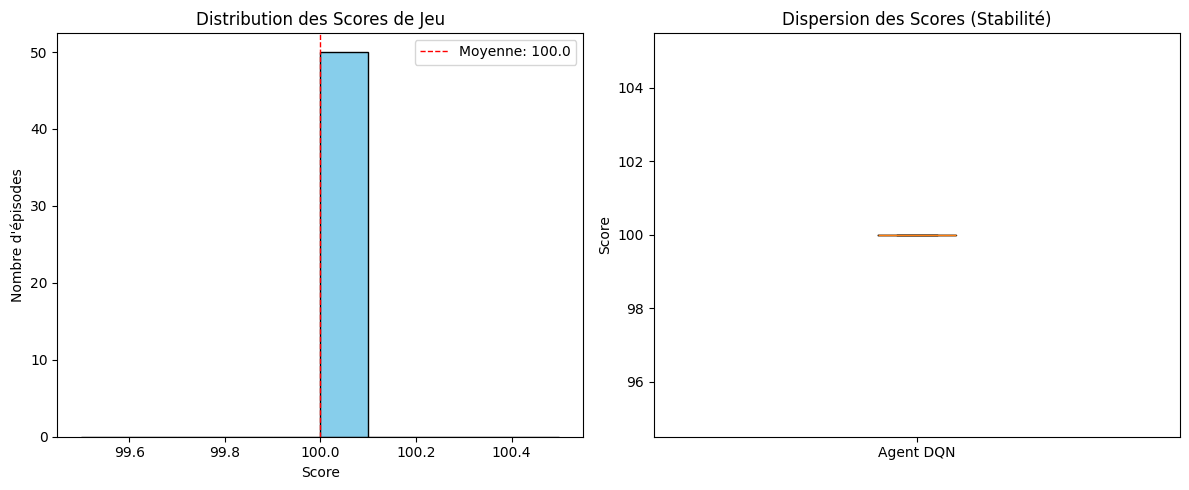

In [6]:
# --- Exécution de l'évaluation ---
# Assurez-vous que 'env' et 'agent' sont bien instanciés (ceux de votre fin d'entraînement)
test_scores, test_rewards = evaluate_agent(env, agent, n_episodes=50)

# --- Visualisation Graphique ---
plt.figure(figsize=(12, 5))

# 1. Histogramme des scores
plt.subplot(1, 2, 1)
plt.hist(test_scores, bins=10, color='skyblue', edgecolor='black')
plt.title('Distribution des Scores de Jeu')
plt.xlabel('Score')
plt.ylabel('Nombre d\'épisodes')
plt.axvline(np.mean(test_scores), color='red', linestyle='dashed', linewidth=1, label=f'Moyenne: {np.mean(test_scores):.1f}')
plt.legend()

# 2. Boxplot (pour voir la stabilité)
plt.subplot(1, 2, 2)
plt.boxplot(test_scores)
plt.title('Dispersion des Scores (Stabilité)')
plt.ylabel('Score')
plt.xticks([1], ['Agent DQN'])

plt.tight_layout()
plt.show()

In [40]:
import pandas as pd 

df = pd.read_csv("dataset.csv")

In [41]:
df.describe()

,x_player,x_enemy_mean,y_enemy_mean,nb_enemies,x_bullet,y_bullet,action
count,7901.000000,7901.000000,7901.000000,7901.000000,7901.000000,7901.000000,7901.000000
mean,0.493854,0.486142,0.469110,19.637135,0.214251,0.293567,0.721681
std,0.204845,0.144394,0.092238,14.746717,0.283123,0.373231,1.035263
min,0.091667,0.000000,0.000000,0.000000,0.000000,-0.065000,0.000000
25%,0.283333,0.426667,0.454286,6.000000,0.000000,0.000000,0.000000
50%,0.516667,0.498333,0.488889,17.000000,0.000000,0.000000,0.000000
75%,0.691667,0.568030,0.515758,32.000000,0.466667,0.708333,1.000000
max,0.875000,0.966667,0.540000,48.000000,0.791667,0.961667,3.000000


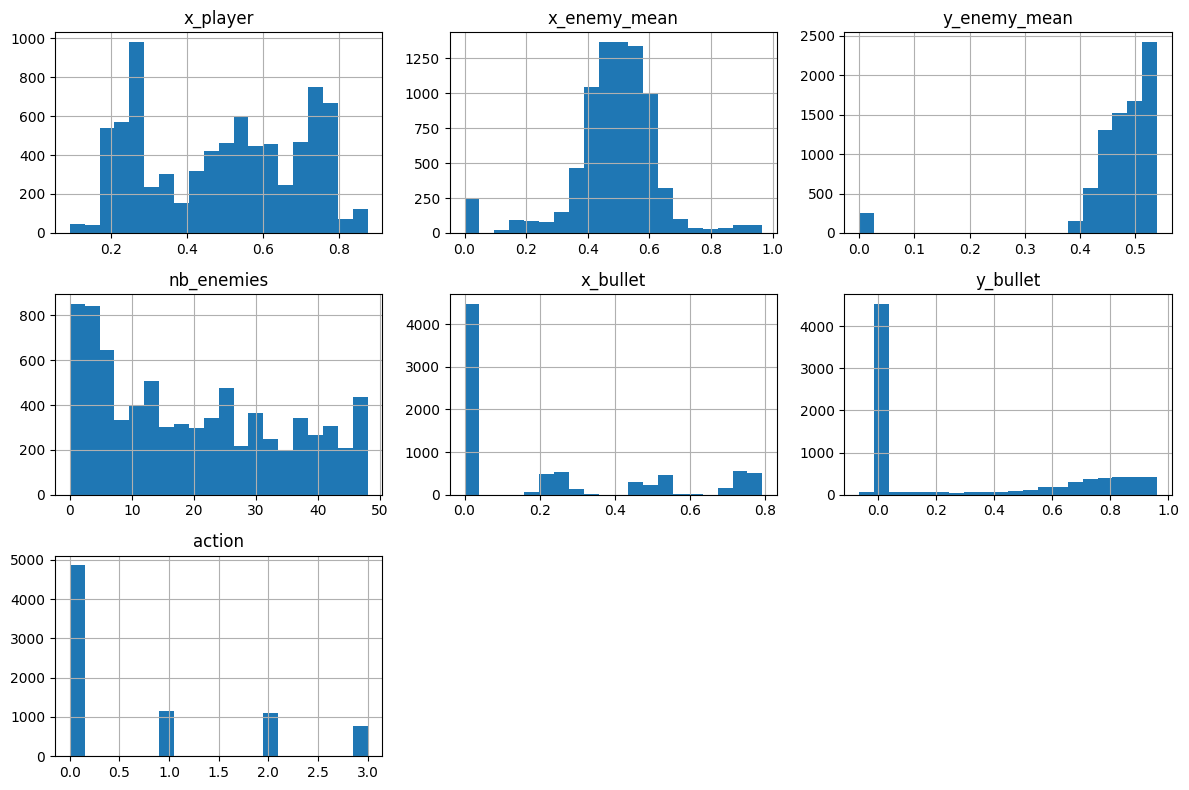

In [42]:
df.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

In [43]:
df_filtered = df[df['action'] != 0]

# Optionnel : réinitialiser les index
df_filtered = df_filtered.reset_index(drop=True)

# Sauvegarder dans un nouveau CSV
df_filtered.to_csv("dataset_filtered.csv", index=False)

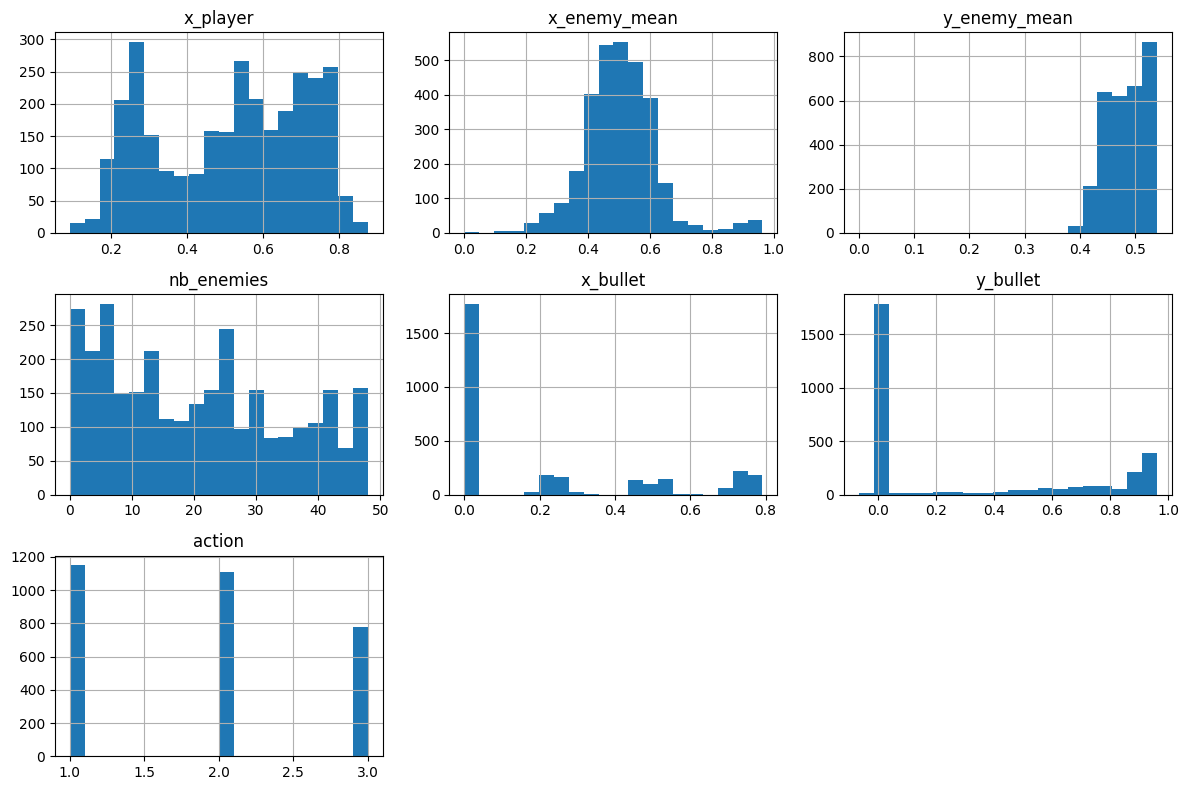

In [44]:
df_filtered.hist(bins=20, figsize=(12,8))
plt.tight_layout()
plt.show()

In [45]:
df_filtered.head()

,x_player,x_enemy_mean,y_enemy_mean,nb_enemies,x_bullet,y_bullet,action
0,0.508333,0.561667,0.393333,48,0.0,0.0,2
1,0.516667,0.563333,0.393333,48,0.0,0.0,2
2,0.525000,0.565000,0.393333,48,0.0,0.0,2
3,0.533333,0.566667,0.393333,48,0.0,0.0,2
4,0.541667,0.568333,0.393333,48,0.0,0.0,2


In [46]:
from sklearn.model_selection import train_test_split, cross_val_predict, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import time
from matplotlib.colors import PowerNorm

In [47]:
train_set, test_set = train_test_split(df_filtered, test_size=0.2, 
                                       random_state=5)

In [48]:
Y_train = train_set["action"].copy()
X_train = train_set.drop("action", axis=1)

In [49]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

Y_train_prep = to_categorical(Y_train-1)

In [52]:


model = Sequential()
model.add(Dense(32, input_dim=X_scaled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes pour action

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
history = model.fit(X_train, Y_train_prep, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50


/Users/Florian/Documents/Ecole/UQAC/Cours-Obsidian/Cours/Cours - UQAC/Fondamentaux de l apprentissage automatique/projets/Space Invaders/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3591 - loss: 1.2144 - val_accuracy: 0.3765 - val_loss: 1.0733
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4151 - loss: 1.0547 - val_accuracy: 0.3765 - val_loss: 1.0404
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5057 - loss: 1.0037 - val_accuracy: 0.4938 - val_loss: 1.0117
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5303 - loss: 0.9543 - val_accuracy: 0.5412 - val_loss: 0.9638
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5237 - loss: 0.9397 - val_accuracy: 0.5103 - val_loss: 0.9405
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5525 - loss: 0.8938 - val_accuracy: 0.5021 - val_loss: 0.9549
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5612 - loss: 0.8902 - val_accuracy: 0.5617 - val_loss: 0.9701
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.5684 - loss: 0.9017 - val_accuracy: 0.5412 - val_loss: 0.9248
E

In [53]:
X_test = test_set.drop("action", axis=1)
Y_test = test_set["action"]
X_test_scaled = scaler.transform(X_test)
Y_test_cat = to_categorical(Y_test - 1)

loss, accuracy = model.evaluate(X_test_scaled, Y_test_cat)
print(f"Test accuracy: {accuracy:.2f}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.4868 - loss: 2.7161
Test accuracy: 0.49
